# 5 Research and Analysis<a id='5_Research'></a>

#### This notebook is meant for more analysis and insights which is needed for the final report and presentation


## Introduction<a id='5.2_Introduction'></a>
#### Capital Fortune  is a real estate company who acquires land and builds housing buildings and are seeking advice from us on how to properly price their homes given the market conditions in NYC, they would like to properly price their houses and find which type of housing yields the greatest net-profits, with that in mind we have set out on a goal to first properly price their houses. We did this by acquiring Zillow's NYC dataset consisting of over 60k houses to find key features for these houses that effect the price and build a predictive model to properly predict Capital Fortune houses. 

#### Our predictive model has identified many key features from Lot size of an house to the school district or zipcode they are in to be key features on evaluating a price of an house. We will be doing a deeper analysis of the market condition and give our best recommendations to Capital Fortune on how to properly price their homes and the type of homes they should target. 

##  Problem<a id=5.3_Problem></a>

#### Capital Fortune main concern is how to properly price their homes and hopefully our predictive model given their home data can gives a good estimate coupled with current market conditions. They also would like to identify the best housing setup which would yield the highest net-profits. Our goal here to identify key problems in solving their issue. 

#### We will utilize our predictive model and find key insights into how Capital Fortune can properly price their homes, by looking into their homes and how to fit into the current market. Here are some key questions we would like to unravel
    - How are newly build homes priced compared to older homes? Do their value differ significantly and if so is it more expensive or cheaper.
    - What are some costs of building such homes and reselling? And which give us the highest return and at what boroughs/neighborhoods?
    - What is the current housing market situation? Is there a lot of demand for houses or is there an over-supply?

##  Imports<a id='5.4_Imports'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as tick
import sklearn.model_selection


from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
import xgboost as xgb

import featuretools as ft
from sklearn import neighbors, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

class style:
   BOLD = '\033[1m'
   END = '\033[0m'
    
#This is a function by Dan Friedman to change the labels of large numbers 
#Here is a link
#https://dfrieds.com/data-visualizations/how-format-large-tick-values.html
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

## Load the Data<a id='5.5_Load'></a>

In [329]:
df = pd.read_csv('../Redo/ny_eda_data.csv').drop(['City', 'ParkingType', 'school_1_level', 'school_1_grades',
              'school_2_level', 'school_1_type', 'school_2_type'], axis=1)
df.rename(columns={'address/streetAddress':'address'}, inplace=True)

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [330]:
df.drop(df[df.HomeType == 'Land'].index, axis=0, inplace=True)
df.HomeType.replace('Residential Income', 'Residential', inplace=True)
df.HomeType.replace(['Other','Mobile / Manufactured'], 'Mixed Use', inplace=True)

In [331]:
def findboro(z):
    bronx = [10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10704, 10803, 10433, 10550,
10454, 10455, 10459, 10474, 10463, 10471, 10466, 10469, 10470, 10475, 10461, 10462,10464, 10465, 10472, 10473]

    brooklyn = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228, 11204, 11218, 11219, 11230,
           11234, 11236, 11239, 11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231, 11242,
           11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222, 11220, 11232, 11206, 11221, 11237, 11249]

    manhattan = [10282, 10069, 10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035,
10010, 10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 
10002, 10003, 10009, 10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032, 10033, 10034, 10040]

    queens = [11109, 11003, 11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 
              11365, 11366, 11367, 11412, 11423, 11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103, 
              11104, 11105, 11106, 11374, 11375, 11379, 11385, 11691, 11692, 11693, 11694, 11695, 11697, 11424,
11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
11368, 11369, 11370, 11372, 11373, 11377, 11378, 11559, 11040, 11001, 11559, 11430, 11020]

    staten = [10302, 10303, 10310, 10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305, 10314]
    
    if z in manhattan:
        x = 'Manhattan'
    elif z in bronx:
        x = 'Bronx'
    elif z in brooklyn:
        x = 'Brooklyn'        
    elif z in queens:
        x = 'Queens'
    elif z in staten:
        x = 'Staten Island'
    else:
        x = 'NYC'
        
    return x

In [334]:
df['Borough'] =  df.ZipCode.apply(findboro)
df = df.drop(df.loc[df.Borough == 'NYC'].index, axis=0)

In [336]:
yearavgprice = df.groupby('YearBuilt').agg({'price':'mean'})
yearavgprice = yearavgprice.reset_index()

Rather than looking at Houses built each year and their prices I believe looking at the decade upon which they were built will suffice

In [337]:
yearavgprice['YearBuilt'] = yearavgprice['YearBuilt'].floordiv(10) * 10

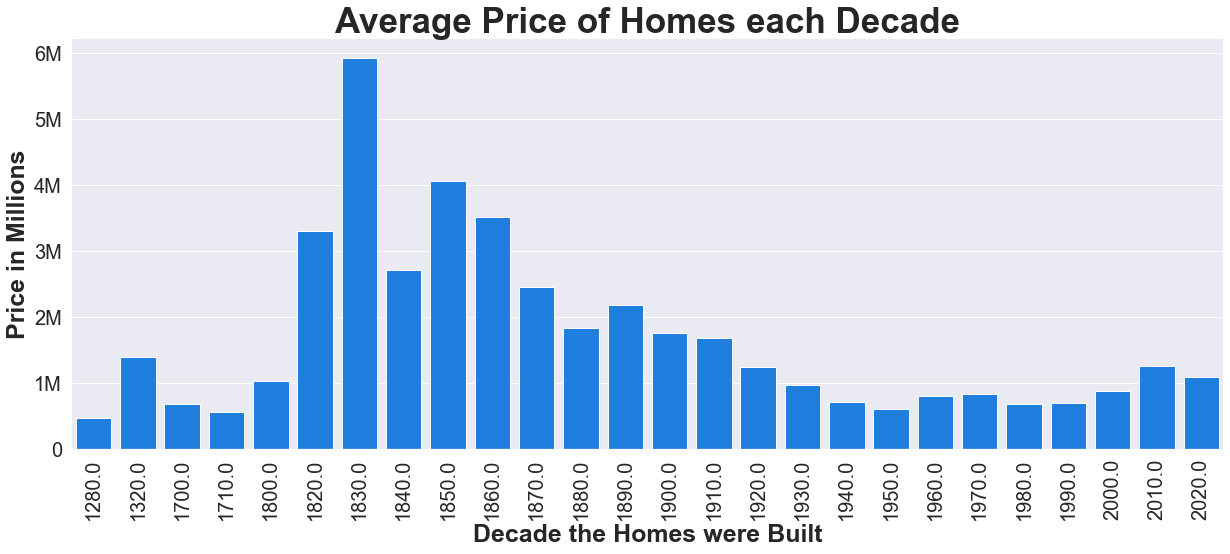

In [389]:
fig, ax = plt.subplots(figsize=(40,15))
sequential_colors = sns.color_palette("RdPu", len(data))
data = yearavgprice.groupby("price").size()
palette = sns.color_palette("Blues",)
order = data.argsort().argsort()
sns.barplot(x='YearBuilt', y='price', data=yearavgprice, color="#007dff", ci=None)
plt.xticks(rotation='90')
plt.title('Average Price of Homes each Decade', fontweight="bold", size=35)
plt.ylabel('Price in Millions', fontweight='bold', size=25)
plt.xlabel('Decade the Homes were Built', fontweight='bold', size=25)
fig.subplots_adjust(bottom=0.500, left=0.5)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
plt.tick_params(axis='both', labelsize=20)

sns.despine()

We see that more expensive houses are older houses but upon a closer look this is because these are homes build in the 1800's and early 1900's in Manhattan and Brooklyn, leading to location being the main driving factor of the price, and many of these houses were remodeled even though their listed built year is older. But notice after the 1950's the average price of houses increase as more recent it is. This puts our clients houses at a premium compared to a older or remodeled old home. 

In [339]:
df[df.YearBuilt >= 1900].Borough.value_counts(normalize=True)

Queens           0.362725
Staten Island    0.228432
Brooklyn         0.201334
Bronx            0.157889
Manhattan        0.049621
Name: Borough, dtype: float64

In [420]:
b_palette = {'Staten Island': '#ECEBF3', 'Bronx' : '#7F6A93', 'Manhattan':'#1A8FE3', 'Brooklyn':'#FF5964', 'Queens':'#64F58D'}

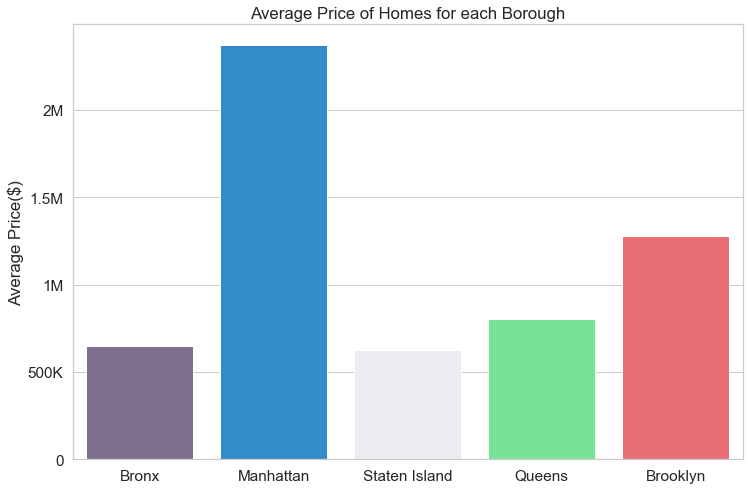

In [680]:
#Lets bar plot the average price of houses by thier boroughs 
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Borough', y='price', data=nyc, ci=None, palette=b_palette)
plt.ylabel('Average Price($)')
plt.xlabel('Borough')
plt.title('Average Price of Homes for each Borough')
plt.ticklabel_format(style='plain', axis='y')
sns.set_style("whitegrid")
ax.set(xlabel=None)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

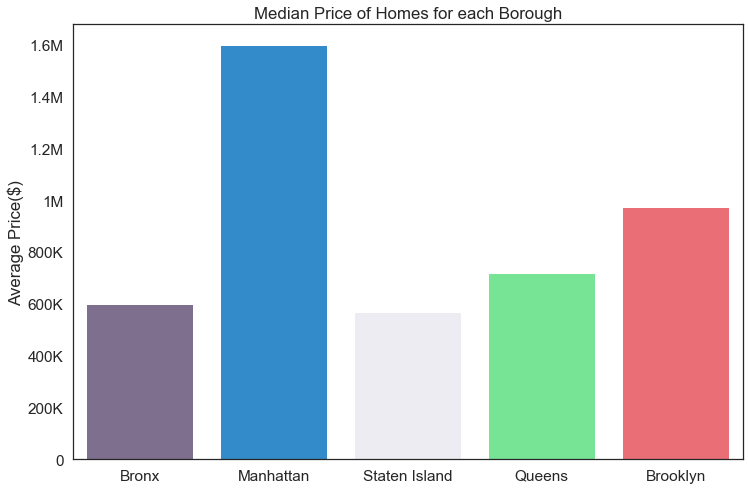

In [678]:
#Lets bar plot the average price of houses by thier boroughs 
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Borough', y='price', data=nyc, ci=None, estimator=np.median, palette=b_palette)
plt.ylabel('Average Price($)')
plt.xlabel('Borough')
plt.title('Median Price of Homes for each Borough')
plt.ticklabel_format(style='plain', axis='y')
sns.set_style("white")
ax.set(xlabel=None)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

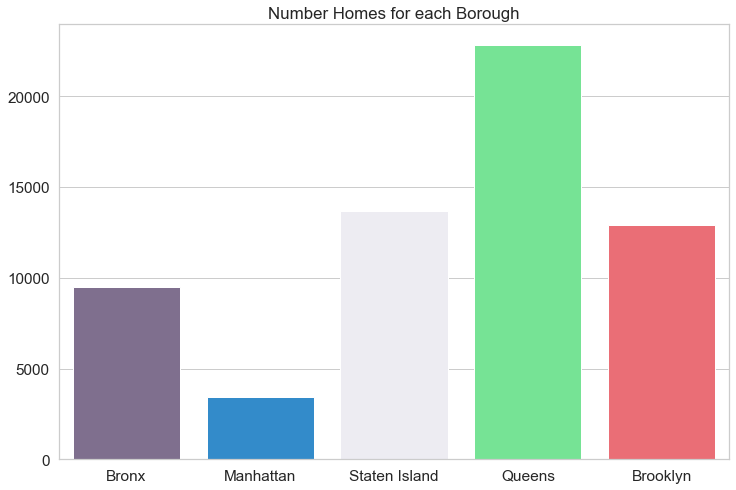

In [427]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='Borough', data=df, palette=b_palette)
plt.xlabel('Borough')
plt.title('Number Homes for each Borough')
ax.set(xlabel=None, ylabel=None)
plt.show()

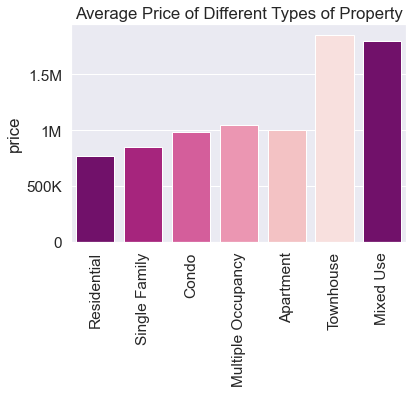

In [363]:
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sequential_colors = sns.color_palette("RdPu")

sns.barplot(x='HomeType', y='price', data=df, ci=None, palette=sequential_colors[::-1])
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_title('Average Price of Different Types of Property')
ax.set(xlabel=None)
plt.show()

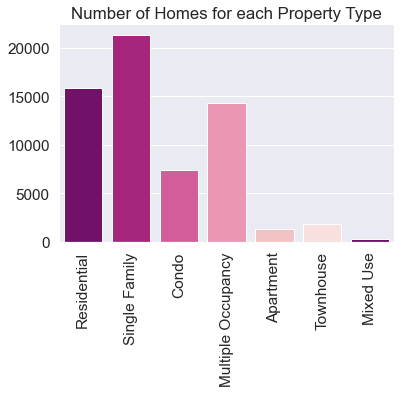

In [364]:
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sequential_colors = sns.color_palette("RdPu")

sns.countplot(x='HomeType', data=df,  palette=sequential_colors[::-1])
plt.xticks(rotation=90)
ax.set_title('Number of Homes for each Property Type')
ax.set(ylabel=None, xlabel=None)
plt.show()

In [683]:
df[df.HomeType == 'Townhouse'].Borough.value_counts()

Brooklyn         583
Staten Island    473
Queens           335
Manhattan        259
Bronx            160
Name: Borough, dtype: int64

Average Price is 925155


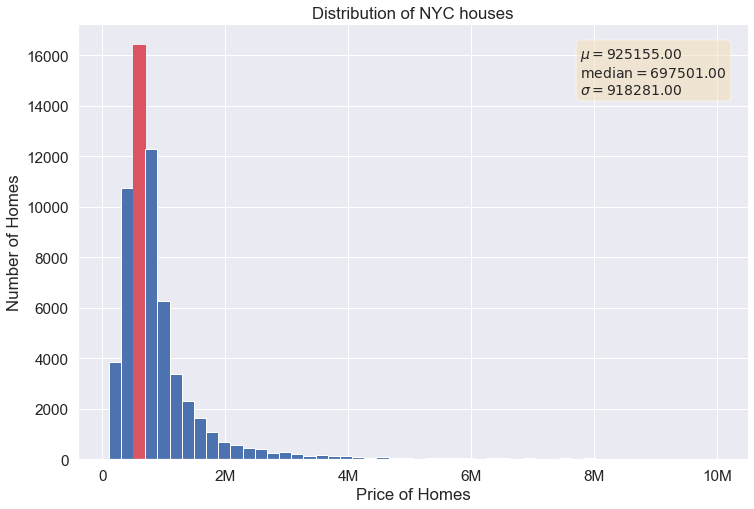

In [467]:
sns.set(font_scale=1.4)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
mean = round(np.mean(df.price))
median = round(np.median(df.price))
std = round(np.std(df.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df.hist('price', bins=50, ax=ax)
ax.set_title('Distribution of NYC houses')
plt.xlabel('Price of Homes')
plt.ylabel('Number of Homes')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.text(0.75, .95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
for bar in ax.patches:
    if bar.get_height() > 16000:
        bar.set_color('#DB5461')
    else:
        continue
print('Average Price is',round(np.mean(df.price)))

In [515]:
gb = xgb.XGBRegressor()

gb.fit(X_train, y_train)
pred_test = gb.predict(X_test)
pred_train = gb.predict(X_train)

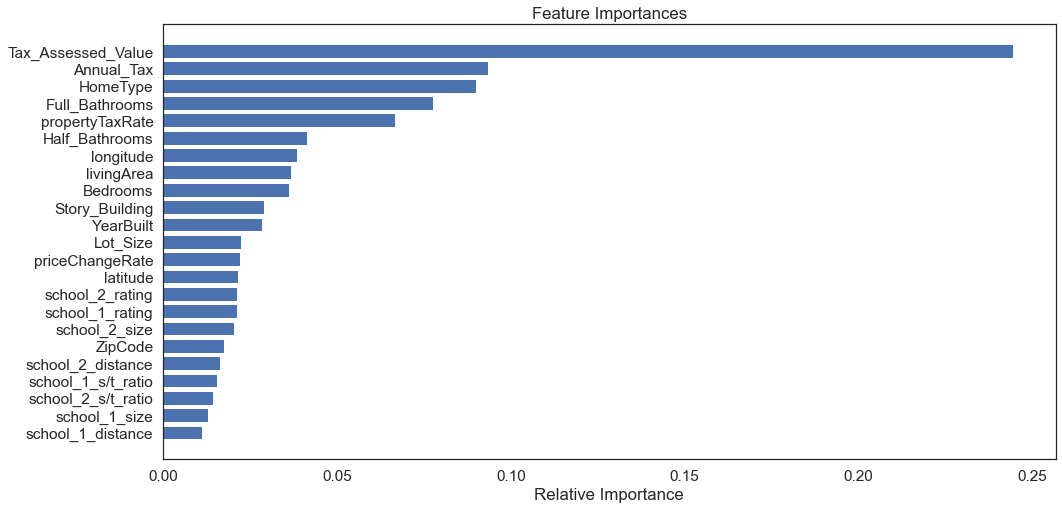

In [518]:
features = X_train.columns
importances = gb.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [542]:
ss = StandardScaler()

X_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(ss.transform(X_test),columns=X_test.columns,index=X_test.index)

In [543]:
log_cols=['livingArea', 'Lot_Size', 'Tax_Assessed_Value']
X_train[log_cols] = np.log(X_train[log_cols])
X_test[log_cols] = np.log(X_test[log_cols])

In [544]:
feature_names = X_train.columns

log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

dtrain = xgb.DMatrix(X_train, label=log_y_train, feature_names=feature_names)

dtest = xgb.DMatrix(X_test, label=log_y_test, feature_names=feature_names)


In [545]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 3,
    'eta':0.05,
    'subsample': 1,
    'colsample_bytree': 0.9,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'mae'
}
num_boost_round = 9999

In [546]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:12.34912
[1]	Test-mae:11.73197
[2]	Test-mae:11.14568
[3]	Test-mae:10.58875
[4]	Test-mae:10.05968
[5]	Test-mae:9.55713
[6]	Test-mae:9.07950
[7]	Test-mae:8.62586
[8]	Test-mae:8.19482
[9]	Test-mae:7.78536
[10]	Test-mae:7.39642
[11]	Test-mae:7.02688
[12]	Test-mae:6.67580
[13]	Test-mae:6.34223
[14]	Test-mae:6.02538
[15]	Test-mae:5.72426
[16]	Test-mae:5.43824
[17]	Test-mae:5.16649
[18]	Test-mae:4.90836
[19]	Test-mae:4.66315
[20]	Test-mae:4.43022
[21]	Test-mae:4.20892
[22]	Test-mae:3.99863
[23]	Test-mae:3.79893
[24]	Test-mae:3.60913
[25]	Test-mae:3.42890
[26]	Test-mae:3.25755
[27]	Test-mae:3.09487
[28]	Test-mae:2.94032
[29]	Test-mae:2.79349
[30]	Test-mae:2.65392
[31]	Test-mae:2.52139
[32]	Test-mae:2.39553
[33]	Test-mae:2.27590
[34]	Test-mae:2.16228
[35]	Test-mae:2.05434
[36]	Test-mae:1.95197
[37]	Test-mae:1.85476
[38]	Test-mae:1.76243
[39]	Test-mae:1.67481
[40]	Test-mae:1.59181
[41]	Test-mae:1.51295
[42]	Test-mae:1.43827
[43]	Test-mae:1.36734
[44]	Test-mae:1.29998
[45]	Test-mae:1

[361]	Test-mae:0.20701
[362]	Test-mae:0.20695
[363]	Test-mae:0.20695
[364]	Test-mae:0.20691
[365]	Test-mae:0.20689
[366]	Test-mae:0.20688
[367]	Test-mae:0.20686
[368]	Test-mae:0.20684
[369]	Test-mae:0.20683
[370]	Test-mae:0.20682
[371]	Test-mae:0.20681
[372]	Test-mae:0.20681
[373]	Test-mae:0.20678
[374]	Test-mae:0.20675
[375]	Test-mae:0.20672
[376]	Test-mae:0.20668
[377]	Test-mae:0.20665
[378]	Test-mae:0.20665
[379]	Test-mae:0.20664
[380]	Test-mae:0.20664
[381]	Test-mae:0.20663
[382]	Test-mae:0.20659
[383]	Test-mae:0.20659
[384]	Test-mae:0.20655
[385]	Test-mae:0.20653
[386]	Test-mae:0.20652
[387]	Test-mae:0.20650
[388]	Test-mae:0.20649
[389]	Test-mae:0.20647
[390]	Test-mae:0.20645
[391]	Test-mae:0.20642
[392]	Test-mae:0.20641
[393]	Test-mae:0.20641
[394]	Test-mae:0.20640
[395]	Test-mae:0.20638
[396]	Test-mae:0.20639
[397]	Test-mae:0.20635
[398]	Test-mae:0.20632
[399]	Test-mae:0.20632
[400]	Test-mae:0.20631
[401]	Test-mae:0.20631
[402]	Test-mae:0.20629
[403]	Test-mae:0.20625
[404]	Test-

[717]	Test-mae:0.20257
[718]	Test-mae:0.20256
[719]	Test-mae:0.20255
[720]	Test-mae:0.20253
[721]	Test-mae:0.20252
[722]	Test-mae:0.20252
[723]	Test-mae:0.20252
[724]	Test-mae:0.20251
[725]	Test-mae:0.20251
[726]	Test-mae:0.20249
[727]	Test-mae:0.20249
[728]	Test-mae:0.20251
[729]	Test-mae:0.20248
[730]	Test-mae:0.20247
[731]	Test-mae:0.20248
[732]	Test-mae:0.20247
[733]	Test-mae:0.20244
[734]	Test-mae:0.20243
[735]	Test-mae:0.20243
[736]	Test-mae:0.20243
[737]	Test-mae:0.20243
[738]	Test-mae:0.20243
[739]	Test-mae:0.20243
[740]	Test-mae:0.20241
[741]	Test-mae:0.20241
[742]	Test-mae:0.20239
[743]	Test-mae:0.20238
[744]	Test-mae:0.20236
[745]	Test-mae:0.20235
[746]	Test-mae:0.20234
[747]	Test-mae:0.20232
[748]	Test-mae:0.20230
[749]	Test-mae:0.20227
[750]	Test-mae:0.20226
[751]	Test-mae:0.20227
[752]	Test-mae:0.20226
[753]	Test-mae:0.20223
[754]	Test-mae:0.20222
[755]	Test-mae:0.20221
[756]	Test-mae:0.20219
[757]	Test-mae:0.20219
[758]	Test-mae:0.20218
[759]	Test-mae:0.20217
[760]	Test-

[1070]	Test-mae:0.20016
[1071]	Test-mae:0.20015
[1072]	Test-mae:0.20014
[1073]	Test-mae:0.20014
[1074]	Test-mae:0.20014
[1075]	Test-mae:0.20013
[1076]	Test-mae:0.20012
[1077]	Test-mae:0.20011
[1078]	Test-mae:0.20011
[1079]	Test-mae:0.20010
[1080]	Test-mae:0.20009
[1081]	Test-mae:0.20009
[1082]	Test-mae:0.20009
[1083]	Test-mae:0.20007
[1084]	Test-mae:0.20006
[1085]	Test-mae:0.20006
[1086]	Test-mae:0.20006
[1087]	Test-mae:0.20005
[1088]	Test-mae:0.20005
[1089]	Test-mae:0.20005
[1090]	Test-mae:0.20004
[1091]	Test-mae:0.20005
[1092]	Test-mae:0.20005
[1093]	Test-mae:0.20004
[1094]	Test-mae:0.20003
[1095]	Test-mae:0.20002
[1096]	Test-mae:0.20002
[1097]	Test-mae:0.20003
[1098]	Test-mae:0.20003
[1099]	Test-mae:0.20002
[1100]	Test-mae:0.20003
[1101]	Test-mae:0.20002
[1102]	Test-mae:0.20001
[1103]	Test-mae:0.20001
[1104]	Test-mae:0.20001
[1105]	Test-mae:0.19999
[1106]	Test-mae:0.20000
[1107]	Test-mae:0.20000
[1108]	Test-mae:0.20000
[1109]	Test-mae:0.19998
[1110]	Test-mae:0.19998
[1111]	Test-mae:

In [547]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:12.34912
[1]	Test-mae:11.73197
[2]	Test-mae:11.14568
[3]	Test-mae:10.58875
[4]	Test-mae:10.05968
[5]	Test-mae:9.55713
[6]	Test-mae:9.07950
[7]	Test-mae:8.62586
[8]	Test-mae:8.19482
[9]	Test-mae:7.78536
[10]	Test-mae:7.39642
[11]	Test-mae:7.02688
[12]	Test-mae:6.67580
[13]	Test-mae:6.34223
[14]	Test-mae:6.02538
[15]	Test-mae:5.72426
[16]	Test-mae:5.43824
[17]	Test-mae:5.16649
[18]	Test-mae:4.90836
[19]	Test-mae:4.66315
[20]	Test-mae:4.43022
[21]	Test-mae:4.20892
[22]	Test-mae:3.99863
[23]	Test-mae:3.79893
[24]	Test-mae:3.60913
[25]	Test-mae:3.42890
[26]	Test-mae:3.25755
[27]	Test-mae:3.09487
[28]	Test-mae:2.94032
[29]	Test-mae:2.79349
[30]	Test-mae:2.65392
[31]	Test-mae:2.52139
[32]	Test-mae:2.39553
[33]	Test-mae:2.27590
[34]	Test-mae:2.16228
[35]	Test-mae:2.05434
[36]	Test-mae:1.95197
[37]	Test-mae:1.85476
[38]	Test-mae:1.76243
[39]	Test-mae:1.67481
[40]	Test-mae:1.59181
[41]	Test-mae:1.51295
[42]	Test-mae:1.43827
[43]	Test-mae:1.36734
[44]	Test-mae:1.29998
[45]	Test-mae:1

[360]	Test-mae:0.20704
[361]	Test-mae:0.20701
[362]	Test-mae:0.20695
[363]	Test-mae:0.20695
[364]	Test-mae:0.20691
[365]	Test-mae:0.20689
[366]	Test-mae:0.20688
[367]	Test-mae:0.20686
[368]	Test-mae:0.20684
[369]	Test-mae:0.20683
[370]	Test-mae:0.20682
[371]	Test-mae:0.20681
[372]	Test-mae:0.20681
[373]	Test-mae:0.20678
[374]	Test-mae:0.20675
[375]	Test-mae:0.20672
[376]	Test-mae:0.20668
[377]	Test-mae:0.20665
[378]	Test-mae:0.20665
[379]	Test-mae:0.20664
[380]	Test-mae:0.20664
[381]	Test-mae:0.20663
[382]	Test-mae:0.20659
[383]	Test-mae:0.20659
[384]	Test-mae:0.20655
[385]	Test-mae:0.20653
[386]	Test-mae:0.20652
[387]	Test-mae:0.20650
[388]	Test-mae:0.20649
[389]	Test-mae:0.20647
[390]	Test-mae:0.20645
[391]	Test-mae:0.20642
[392]	Test-mae:0.20641
[393]	Test-mae:0.20641
[394]	Test-mae:0.20640
[395]	Test-mae:0.20638
[396]	Test-mae:0.20639
[397]	Test-mae:0.20635
[398]	Test-mae:0.20632
[399]	Test-mae:0.20632
[400]	Test-mae:0.20631
[401]	Test-mae:0.20631
[402]	Test-mae:0.20629
[403]	Test-

[716]	Test-mae:0.20258
[717]	Test-mae:0.20257
[718]	Test-mae:0.20256
[719]	Test-mae:0.20255
[720]	Test-mae:0.20253
[721]	Test-mae:0.20252
[722]	Test-mae:0.20252
[723]	Test-mae:0.20252
[724]	Test-mae:0.20251
[725]	Test-mae:0.20251
[726]	Test-mae:0.20249
[727]	Test-mae:0.20249
[728]	Test-mae:0.20251
[729]	Test-mae:0.20248
[730]	Test-mae:0.20247
[731]	Test-mae:0.20248
[732]	Test-mae:0.20247
[733]	Test-mae:0.20244
[734]	Test-mae:0.20243
[735]	Test-mae:0.20243
[736]	Test-mae:0.20243
[737]	Test-mae:0.20243
[738]	Test-mae:0.20243
[739]	Test-mae:0.20243
[740]	Test-mae:0.20241
[741]	Test-mae:0.20241
[742]	Test-mae:0.20239
[743]	Test-mae:0.20238
[744]	Test-mae:0.20236
[745]	Test-mae:0.20235
[746]	Test-mae:0.20234
[747]	Test-mae:0.20232
[748]	Test-mae:0.20230
[749]	Test-mae:0.20227
[750]	Test-mae:0.20226
[751]	Test-mae:0.20227
[752]	Test-mae:0.20226
[753]	Test-mae:0.20223
[754]	Test-mae:0.20222
[755]	Test-mae:0.20221
[756]	Test-mae:0.20219
[757]	Test-mae:0.20219
[758]	Test-mae:0.20218
[759]	Test-

[1069]	Test-mae:0.20016
[1070]	Test-mae:0.20016
[1071]	Test-mae:0.20015
[1072]	Test-mae:0.20014
[1073]	Test-mae:0.20014
[1074]	Test-mae:0.20014
[1075]	Test-mae:0.20013
[1076]	Test-mae:0.20012
[1077]	Test-mae:0.20011
[1078]	Test-mae:0.20011
[1079]	Test-mae:0.20010
[1080]	Test-mae:0.20009
[1081]	Test-mae:0.20009
[1082]	Test-mae:0.20009
[1083]	Test-mae:0.20007
[1084]	Test-mae:0.20006
[1085]	Test-mae:0.20006
[1086]	Test-mae:0.20006
[1087]	Test-mae:0.20005
[1088]	Test-mae:0.20005
[1089]	Test-mae:0.20005
[1090]	Test-mae:0.20004
[1091]	Test-mae:0.20005
[1092]	Test-mae:0.20005
[1093]	Test-mae:0.20004
[1094]	Test-mae:0.20003
[1095]	Test-mae:0.20002
[1096]	Test-mae:0.20002
[1097]	Test-mae:0.20003
[1098]	Test-mae:0.20003
[1099]	Test-mae:0.20002
[1100]	Test-mae:0.20003
[1101]	Test-mae:0.20002
[1102]	Test-mae:0.20001
[1103]	Test-mae:0.20001
[1104]	Test-mae:0.20001
[1105]	Test-mae:0.19999
[1106]	Test-mae:0.20000
[1107]	Test-mae:0.20000
[1108]	Test-mae:0.20000
[1109]	Test-mae:0.19998
[1110]	Test-mae:

In [548]:
bmlog_pred_test = (best_model.predict(dtest))
bmlog_pred_train = (best_model.predict(dtrain))
pred_test = best_model.predict(dtest)
pred_train = best_model.predict(dtrain)

In [549]:
from sklearn.metrics import mean_absolute_error

print("MAE of Y_train log GB prediction with HP Tuning:",mean_absolute_error(log_y_train, bmlog_pred_train))
print("MAE of Y_test log GB prediction with HP Tuning:",mean_absolute_error(log_y_test, bmlog_pred_test))

MAE of Y_train log GB prediction with HP Tuning: 0.14255364565654557
MAE of Y_test log GB prediction with HP Tuning: 0.1994442617794904


In [551]:
bm_pred_test = np.exp(bmlog_pred_test)
bm_pred_train = np.exp(bmlog_pred_train)

print("MAE of Y_train GB prediction with HP Tuning:",mean_absolute_error(y_train, bm_pred_train))
print("MAE of Y_test GB prediction with HP Tuning:",mean_absolute_error(y_test, bm_pred_test))

MAE of Y_train GB prediction with HP Tuning: 134938.22867011122
MAE of Y_test GB prediction with HP Tuning: 198354.63179122139


In [565]:
import datetime as dt
med_df = pd.read_csv("../data/MSPUS.csv")
med_df.DATE = pd.to_datetime(med_df.DATE)
med_df.head()

,DATE,MSPUS
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


In [579]:
med_df = med_df[med_df['DATE'].dt.year >= 2000]
med_df.reset_index(inplace=True)

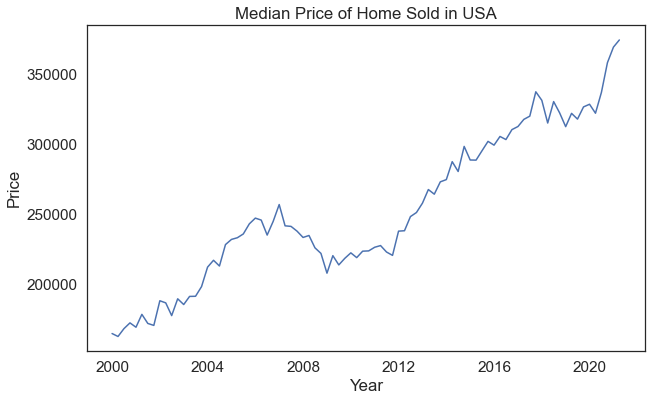

In [589]:
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='DATE', y='MSPUS', data=med_df)
plt.title('Median Price of Home Sold in USA')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [590]:
Brooklyn = df[df['Borough'] == 'Brooklyn']
Queens = df[df['Borough'] == 'Queens']
Staten_Island = df[df['Borough'] == 'Staten Island']
Bronx = df[df['Borough'] == 'Bronx']
Manhattan = df[df['Borough'] == 'Manhattan']

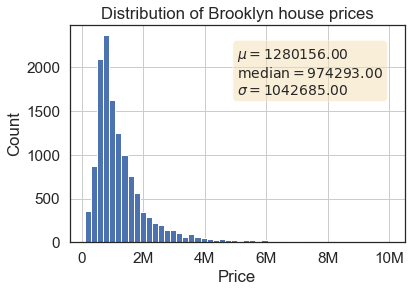

In [591]:
#Lets look at the distribution for each of the boroungs now 
mean = round(np.mean(Brooklyn.price))
median = round(np.median(Brooklyn.price))
std = round(np.std(Brooklyn.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

Brooklyn.hist('price', bins=50, range=[100000,10000000])
ax = plt.gca()
ax.set_title('Distribution of Brooklyn house prices')
ax.text(0.5, .9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Price')
plt.ylabel('Count')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

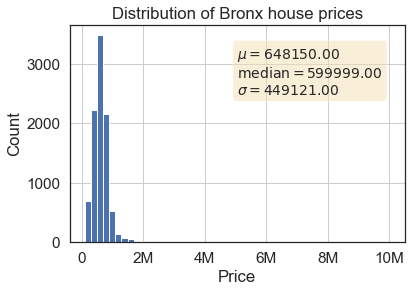

In [592]:
mean = round(np.mean(Bronx.price))
median = round(np.median(Bronx.price))
std = round(np.std(Bronx.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

Bronx.hist('price', bins=50, range=[100000,10000000])
ax = plt.gca()
ax.set_title('Distribution of Bronx house prices')
ax.text(0.5, .9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Price')
plt.ylabel('Count')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

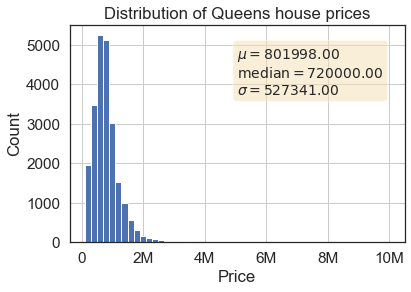

In [593]:
mean = round(np.mean(Queens.price))
median = round(np.median(Queens.price))
std = round(np.std(Queens.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

Queens.hist('price', bins=50, range=[100000,10000000])
ax = plt.gca()
ax.set_title('Distribution of Queens house prices')
ax.text(0.5, .9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Price')
plt.ylabel('Count')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

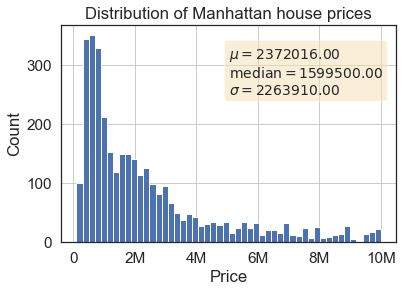

In [594]:
mean = round(np.mean(Manhattan.price))
median = round(np.median(Manhattan.price))
std = round(np.std(Manhattan.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

Manhattan.hist('price', bins=50, range=[100000,10000000])
ax = plt.gca()
ax.set_title('Distribution of Manhattan house prices')
ax.text(0.5, .9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Price')
plt.ylabel('Count')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

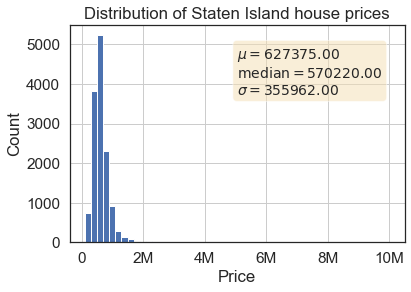

In [595]:
mean = round(np.mean(Staten_Island.price))
median = round(np.median(Staten_Island.price))
std = round(np.std(Staten_Island.price))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mean, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (std, )))

Staten_Island.hist('price', bins=50, range=[100000,10000000])
ax = plt.gca()
ax.set_title('Distribution of Staten Island house prices')
ax.text(0.5, .9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Price')
plt.ylabel('Count')
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

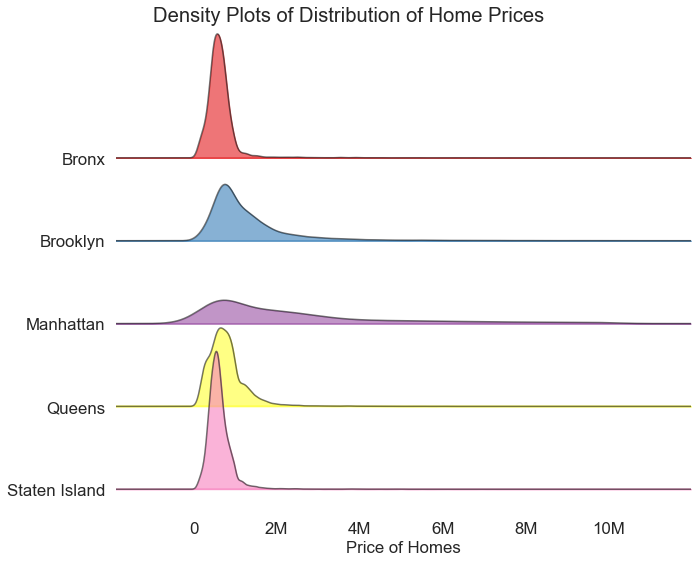

In [672]:
import joypy as jp 
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

original_cmap = plt.cm.Set1

fig, ax = plt.subplots(figsize=(10,8))
jp.joyplot(data = df, by='Borough', column='price', alpha=0.6, colormap= original_cmap, ax=ax)
fig.suptitle('Density Plots of Distribution of Home Prices')
plt.xlabel('Price of Homes')
plt.gca().xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))